In [20]:
import kagglehub
import os

# Download dataset
dataset_path = kagglehub.dataset_download("rakeshdasdata/rakesh-fer-dataset")

print("Dataset downloaded to:", dataset_path)
print("Contents:", os.listdir(dataset_path))

Dataset downloaded to: /kaggle/input/rakesh-fer-dataset
Contents: ['test', 'train']


In [21]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torch.nn as nn
from torchvision import models
from tqdm import tqdm


train_dir='/kaggle/input/rakesh-fer-dataset/train'
test_dir='/kaggle/input/rakesh-fer-dataset/test'

device =torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"deice:{device}")
#transforms
train_trans=transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((48,48)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])
])

test_transforms=transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((48,48)),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

#datasets
train_dataset=datasets.ImageFolder(train_dir,transform=train_trans)
test_dataset=datasets.ImageFolder(test_dir,transform=test_transforms)

#load
train_loader=DataLoader(train_dataset,batch_size=64,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=64,shuffle=True)


print("data loaded")
print("training data",len(train_dataset))


deice:cpu
data loaded
training data 28709


In [22]:


batchsize=32
epochs=1
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device{device}")
#model
def getmodel():
  model=models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
  model.classifier[1]=nn.Linear(model.classifier[1].in_features,7)
  return model.to(device)

model = getmodel()

criterion=nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer=optim.Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=3,factor=0.5)

bestacc=0.0
print("Training")

for epoch in range(epochs):
  running_loss=0.0
  correct=0
  total=0
  model.train()


  torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_acc': bestacc
    }, 'checkpoint.pth')
    
  loop = tqdm(train_loader,leave=True)

  for inputs,labels in loop:
    inputs=inputs.to(device)
    labels=labels.to(device)
    optimizer.zero_grad()
    outputs=model(inputs)
    loss=criterion(outputs,labels)
    loss.backward()
    optimizer.step()
    
    running_loss+=loss.item()
    _,predicted=torch.max(outputs.data,1)
    total+=labels.size(0)
    correct+=(predicted==labels).sum().item()


    loop.set_description(f"epoch[{epoch+1}/{epochs}]")
    loop.set_postfix(loss=round(loss.item(),3),acc=round(100*correct/total,2))


  #eval
  model.eval()
  correct=0
  total=0
  with torch.no_grad():
    for inputs,labels in test_loader:
      inputs=inputs.to(device)
      labels=labels.to(device)
      outputs=model(inputs)
      _,predicted=torch.max(outputs.data,1)
      total+=labels.size(0)
      correct+=(predicted==labels).sum().item()
  acc=100*correct/total
  print(f"Validation accuracy:{round(acc,2)}%")


  scheduler.step(acc)

  if acc>bestacc:
    bestacc=acc
    torch.save(model.state_dict(),'model.pth')
    print("model saved")
  print(f"Final best accuracy: {round(bestacc,2)}%")


devicecpu
Training


epoch[1/1]: 100%|██████████| 449/449 [06:06<00:00,  1.22it/s, acc=46.4, loss=1.2] 


Validation accuracy:54.99%
model saved
Final best accuracy: 54.99%


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
from tqdm import tqdm

import torch
import torch.nn as nn
from torchvision import models

def getmodel():
  model=models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
  model.classifier[1]=nn.Linear(model.classifier[1].in_features,7)
  return model.to(device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#load model
model=getmodel()
model.load_state_dict(torch.load('model.pth'))
model.eval()

predictions=[]
filenames=[]

print("Prediction")

with torch.no_grad():
  for i in tqdm(range(len(test_dataset))):
    #img
    img,_=test_dataset[i]
    img=img.unsqueeze(0).to(device)

    #filename
    full_path=test_dataset.imgs[i][0]
    filename=os.path.basename(full_path)
    #prediction
    output=model(img)
    _,pred_tensor=torch.max(output,1)
    predi=pred_tensor.item()
    predlabel=train_dataset.classes[predi]
    predictions.append(predlabel)
    filenames.append(filename)


resdf=pd.DataFrame({
    'image_name':filenames,
    'label':predictions
})

#save to drive
savepath='/kaggle/working/submission.csv'
resdf.to_csv(savepath,index=False)
print(f"submission saved to:{savepath}")

Prediction


100%|██████████| 7178/7178 [01:49<00:00, 65.66it/s]

submission saved to:/kaggle/working/submission.csv


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


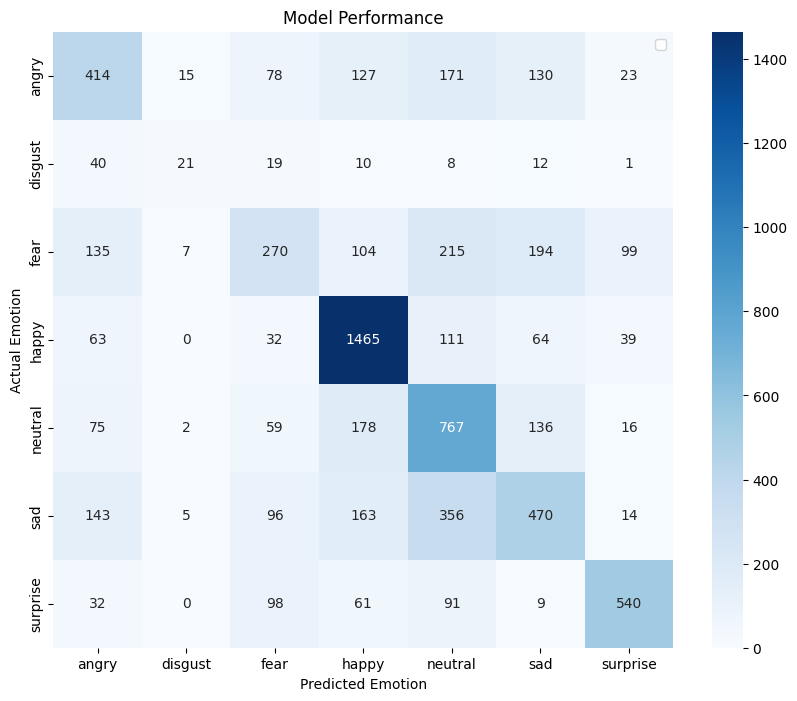

In [24]:
#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

truelabel=[label for _,label in test_dataset.samples]
predi=[train_dataset.class_to_idx[pred] for pred in predictions]

confmat=confusion_matrix(truelabel,predi)
#plot
plt.figure(figsize=(10,8))
sns.heatmap(confmat,annot=True,fmt='d',cmap='Blues',
           xticklabels=train_dataset.classes,
           yticklabels=train_dataset.classes
           )
plt.ylabel('Actual Emotion')
plt.xlabel('Predicted Emotion')
plt.title('Model Performance')
plt.legend()
plt.show()

